In [1]:
import dill
from main.manipulation import Manipulation
from main.data_processing import evaluate_profile, get_social_welfare_of_alternative
import pandas as pd
import numpy as np
from main.manipulation_utils import get_children_generation_options, check_transitivity, one_cost_children_generation, useful_change
from IPython.display import display
from copy import copy
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [61]:
def get_qualities_of_winners(input_data, df_result, k, method):
    """
    input_data: list of profiles
    df_result: processed dataframe with the results
    """
    num_alt = len(input_data[0][0])
    alph_order = {}
    for i in range(num_alt):
        alph_order[i] = i
        
    winners = df_result['result'].apply(lambda d: d[max(d.keys())][0] if d else None).values
    same_winner_times = 0
    qualities = []
    for i in range(len(winners)):
        if not pd.isnull(winners[i]):
            true_win = evaluate_profile(input_data[i], k, method, alph_order)[0]
            if true_win == winners[i]:
                same_winner_times+=1
            qualities.append(get_social_welfare_of_alternative(input_data[i], true_win) - get_social_welfare_of_alternative(input_data[i], winners[i]))
    return qualities, same_winner_times

# data load and set-up

In [2]:
with open('data/results/total_result.pkl', 'rb') as f:
    total_result = dill.load(f)

### calculate quality of winners

In [3]:
with open('data/our_data_complete.pkl', 'rb') as f:
    input_data_complete = dill.load(f)
with open('data/our_data_incomplete.pkl', 'rb') as f:
    input_data_incomplete = dill.load(f)

In [5]:
data_df = pd.DataFrame(total_result).T
data_df.columns = ['convergence', 'result']

In [6]:
data_df

convergence  \
3 10 ic 131 1 approval 100 0 True True True True        True   
        132 1 approval 100 0 True True True True        True   
        133 1 approval 100 0 True True True True        True   
        134 1 approval 100 0 True True True True        True   
        135 1 approval 100 0 True True True True        True   
...                                                      ...   
7 20 ic 45  1 approval 100 0 True True True True        True   
        46  1 approval 100 0 True True True True        True   
        47  1 approval 100 0 True True True True   hard_exit   
        48  1 approval 100 0 True True True True        True   
        49  1 approval 100 0 True True True True        True   

                                                                                             result  
3 10 ic 131 1 approval 100 0 True True True True                                        {0: (1, 8)}  
        132 1 approval 100 0 True True True True                                                 {}  
        133 1 approval 100 0 True True True True                  {0: (0, 6), 1: (2, 4), 2: (0, 1)}  
        134 1 approval 100 0 True True True True                                                 {}  
        135 1 approval 100 0 True True True True                  {0: (0, 1), 1: (2, 7), 2: (0, 4)}  
...                                                                                             ...  
7 20 ic 45  1 approval 100 0 True True True True  {0: (4, 14), 1: (1, 1), 2: (4, 16), 3: (1, 13)...  
        46  1 approval 100 0 True True True True                                                 {}  
        47  1 approval 100 0 True True True True                                          hard_exit  
        48  1 approval 100 0 True True True True  {0: (2, 7), 1: (4, 11), 2: (2, 17), 3: (4, 10)...  
        49  1 approval 100 0 True True True True                                                 {}  

[11046 rows x 2 columns]

# Plots
to check:

1. number of rounds to convergence (putting an upper bound for cycles)

2. number of non-manipulable profiles

3. quality of winner in truthful vs. equilibrium profile. 
- Definition: input: one alternative `a` and one truthful profile. For every voter, look at her preference. The quality of the alternative a is #1s - #(-1s) in the row of `a`. Sum up the quality of a for all voters. This is the social welfare.

Calculate social welfare for truthful winner and convergence winner, and subtract latter from former.

4. number of times where the winner was the same as the truthful one
----------------------------------------------------


for plotting:

1. x: percentage of profiles that have converged ; y: number of rounds
each plot includes: one distribution, different lines for (n,m)
different plots for k, approval/veto, om/add/flip, linear orders 

2. x: percentage of non-manipulable profiles ; y: om/ad/flip (7 combinations)
each plot includes: one distribution, different dots for (n,m)
different plots for k, approval/veto, linear orders

3. x: percentage of profiles with that sw; y: social welfare (0 to 1)
each plot includes: one distribution, different lines for (n,m)
different plots for k, approval/veto, om/add/flip, linear orders

4. x: percentage of profiles with true winner ; y: om/ad/flip (7 combinations)
each plot includes: one distribution, different dots for (n,m)
different plots for k, approval/veto, linear orders


In [7]:
k = 1
method = 'approval'
completeness = True
cycle_limit = 100

In [63]:
inds = []
convergence_rounds_all = []
qualities_all = []
same_winner_times_all = []

for num_alt in [3, 4, 5, 6]:
    for d_type in ["2urn", "ic"]:
        for num_vot in [10, 20, 50]:
            dft = data_df.loc[(num_alt, num_vot, d_type, slice(None), k, method, cycle_limit, 0, True, True, True, completeness)]
            convergence_rounds = dft['result'].apply(lambda d: max(d.keys())+1 if d else 0)
            input_data = {True: input_data_complete, False: input_data_incomplete}[completeness]
            qualities, same_winner_times =get_qualities_of_winners(input_data[(num_vot, num_alt, d_type)], dft, k, method)
            
            inds.append((num_alt, num_vot, d_type))
            convergence_rounds_all.append(convergence_rounds)
            qualities_all.append(qualities)
            same_winner_times_all.append(same_winner_times)
            
            print(f'k: {k}, num_alt: {num_alt}, num_vot: {num_vot}, d_type: {d_type}: percent of converged {dft["convergence"].max()*100}%, convergence rounds: mean={convergence_rounds.mean()}, max={convergence_rounds.max()}, std={convergence_rounds.std():.2f}, mean_quality: {np.mean(qualities):.2f}, times with no winner change: {same_winner_times}')

k: 1, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.44, max=6, std=0.95, mean_quality: -0.82, times with no winner change: 20
k: 1, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.51, max=5, std=1.07, mean_quality: -0.36, times with no winner change: 24
k: 1, num_alt: 3, num_vot: 50, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.79, max=8, std=1.90, mean_quality: -1.59, times with no winner change: 22
k: 1, num_alt: 3, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=0.715, max=6, std=1.16, mean_quality: 5.01, times with no winner change: 23
k: 1, num_alt: 3, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=1.1, max=14, std=2.22, mean_quality: -0.94, times with no winner change: 30
k: 1, num_alt: 3, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=2.43, max=17, std=5.08, mean_quality: -2.15,

In [64]:
means = [x.mean() for x in convergence_rounds_all]
stds = [x.std() for x in convergence_rounds_all]

In [65]:
df = pd.DataFrame({'means': means, 'stds': stds}, index=pd.MultiIndex.from_tuples(inds, names=['num_alt', 'num_vot', 'd_type'])).reset_index()

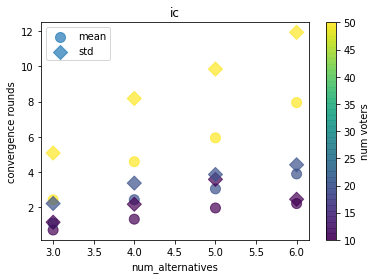

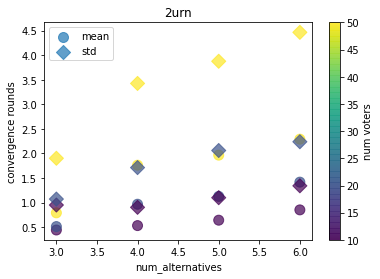

In [67]:
for d_type in ['ic', '2urn']:
    dft = df[df['d_type']==d_type]
    plt.scatter(dft['num_alt'], dft['means'], c=dft['num_vot'], s =100, alpha=0.7, label='mean')
    plt.scatter(dft['num_alt'], dft['stds'], c=dft['num_vot'], s =100, marker='D', alpha=0.7, label='std')
    plt.title(d_type)
    plt.legend()
    plt.xlabel('num_alternatives')
    plt.ylabel('convergence rounds')
    cbar = plt.colorbar()
    cbar.set_label('num voters')
    plt.show()